In [1]:
# Set up AMD GPU (change if using Nvidia)
import plaidml.keras
plaidml.keras.install_backend()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [4]:
from keras import callbacks, models, layers

# Read data

In [5]:
data = pd.read_csv('D:/wildfires/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Drop unnecessary columns

In [6]:
data.drop(['Unnamed: 0.1', 'index_x', 'FOD_ID', 'FIRE_NAME', 'DISCOVERY_DOY_SCALED',
           'x_fire', 'y_fire', 'z_fire',
           'index_y', 'Begin', 'End', 'Country', 'Day', 'ICAO', 'Latitude', 'Longitude', 'Month', 'STATION NAME',
           'State', 'Station', 'USAF', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 
           'WBAN', 'Year', 'doy', 'x', 'y', 'z',
          ],
         axis='columns', inplace=True)

In [7]:
gc.collect()

2476

In [8]:
data.columns

Index(['STAT_CAUSE_DESCR', 'FIRE_YEAR', 'DISCOVERY_DOY', 'FIRE_SIZE',
       'LATITUDE', 'LONGITUDE', 'STATE', 'CONTAINED', 'DISCOVERY_MONTH',
       'DISTANCE_CITY_1000000', 'DISTANCE_CITY_100000', 'DISTANCE_CITY_10000',
       'DISTANCE_CITY_1000', 'APPROX_ELEVATION', 'DewPoint', 'Elevation',
       'Fog', 'FunnelCloud', 'Gust', 'Hail', 'MaxTemp', 'MaxWindspeed',
       'MinTemp', 'Precip', 'Rain', 'SeaLevelPressure', 'Snow', 'SnowDepth',
       'StationPressure', 'Temp', 'Thunder', 'Visibility', 'Windspeed'],
      dtype='object')

# Drop unknown fires

In [9]:
data = data[data['STAT_CAUSE_DESCR'] != 'Missing/Undefined']
data = data[data['STAT_CAUSE_DESCR'] != 'Miscellaneous']

In [10]:
gc.collect()

60

# Split into features/labels and one-hot code

Also convert missing values to `np.nan`.

In [11]:
data.drop('STAT_CAUSE_DESCR', axis='columns').iloc[:,8:].columns

Index(['DISTANCE_CITY_1000000', 'DISTANCE_CITY_100000', 'DISTANCE_CITY_10000',
       'DISTANCE_CITY_1000', 'APPROX_ELEVATION', 'DewPoint', 'Elevation',
       'Fog', 'FunnelCloud', 'Gust', 'Hail', 'MaxTemp', 'MaxWindspeed',
       'MinTemp', 'Precip', 'Rain', 'SeaLevelPressure', 'Snow', 'SnowDepth',
       'StationPressure', 'Temp', 'Thunder', 'Visibility', 'Windspeed'],
      dtype='object')

#### Zero-imputing for some features -- see EDA.ipynb

In [12]:
for zcol in ['Gust', 'MaxWindspeed', 'Precip', 'SnowDepth', 'Visibility', 'Windspeed']:
    data.loc[data[zcol].isna(), zcol] = 0

In [13]:
Y = pd.get_dummies(data['STAT_CAUSE_DESCR'].cat.remove_unused_categories())
X = pd.get_dummies(data.drop('STAT_CAUSE_DESCR', axis='columns').iloc[:,8:])

for na in [9999.9, 999.9, 99.99]:
    X[X == na] = np.nan

In [14]:
X.shape

(1389937, 24)

# Train/test split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42)

# Impute still-missing features

#### Mean imputing for some features -- see EDA.ipynb

In [16]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [17]:
imp.fit(X_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [18]:
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Scale the features

In [19]:
scale = MinMaxScaler()

In [20]:
scale.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

# Define the model

In [22]:
model = models.Sequential()

model.add(layers.Dense(512, input_shape=(X.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Dense(512))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))


model.add(layers.Dense(Y.shape[1], activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

INFO:plaidml:Opening device "opencl_amd_tonga.0"


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               12800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
__________

# Fit model

In [24]:
history = model.fit(x = X_train, y = Y_train,
                    validation_data = (X_test, Y_test),
                    batch_size = 10000, epochs=100,
                    callbacks = [callbacks.EarlyStopping(patience=5)])

Train on 1250943 samples, validate on 138994 samples
Epoch 1/100
1250943/1250943 [==============================] - 33s 27us/step - loss: 1.5819 - categorical_accuracy: 0.4500 - val_loss: 1.9190 - val_categorical_accuracy: 0.3056
Epoch 2/100
1250943/1250943 [==============================] - 18s 15us/step - loss: 1.4671 - categorical_accuracy: 0.4848 - val_loss: 1.9068 - val_categorical_accuracy: 0.2397
Epoch 3/100
1250943/1250943 [==============================] - 19s 15us/step - loss: 1.4359 - categorical_accuracy: 0.4964 - val_loss: 1.7684 - val_categorical_accuracy: 0.3964
Epoch 4/100
1250943/1250943 [==============================] - 18s 15us/step - loss: 1.4161 - categorical_accuracy: 0.5037 - val_loss: 1.6171 - val_categorical_accuracy: 0.4381
Epoch 5/100
1250943/1250943 [==============================] - 19s 15us/step - loss: 1.4002 - categorical_accuracy: 0.5096 - val_loss: 1.5267 - val_categorical_accuracy: 0.4625
Epoch 6/100
1250943/1250943 [==============================] -

In [25]:
data['STAT_CAUSE_DESCR'].groupby(data['STAT_CAUSE_DESCR']).count() / data.shape[0]

STAT_CAUSE_DESCR
Arson                0.202495
Campfire             0.054779
Children             0.044007
Debris Burning       0.308667
Equipment Use        0.106200
Fireworks            0.008274
Lightning            0.200346
Miscellaneous        0.000000
Missing/Undefined    0.000000
Powerline            0.010395
Railroad             0.024069
Smoking              0.038037
Structure            0.002731
Name: STAT_CAUSE_DESCR, dtype: float64

In [26]:
Y_pred = model.predict(X_test)

In [27]:
C = confusion_matrix(np.argmax(Y_test.values, axis=-1), np.argmax(Y_pred, axis=-1))

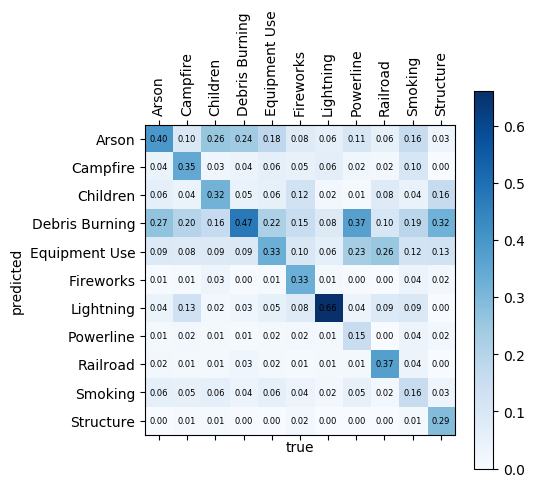

In [28]:
fig, ax = plt.subplots(figsize=(5,5), dpi=100)

Cnorm = C / C.sum(axis=0)

m = ax.matshow(Cnorm, cmap='Blues')
for i in range(11):
    for j in range(11):
        ax.text(j, i, '{:0.2f}'.format(Cnorm[i,j]), ha='center', va='center', fontsize=6)
        
fig.colorbar(m)

ax.set_xlabel("true")
plt.yticks(ticks=np.arange(11), labels=Y.columns)
plt.xticks(ticks=np.arange(11), labels=Y.columns, rotation=90)
ax.set_ylabel('predicted')
plt.show()